## Описание проекта
Данный проект проводится с целью обнаружения причин возникновения убытков у компании при масштабных вложениях в маркетинг. 
В рамках исследования планируется:

1. Провести предварительный анализ имеющихся данных и их предобработка в случае необходимости.

2. Рассчитать метрики LTV, ROI, Conversion Rate и Retention Rate, а также подготовить их визуализацию. Для этого мы будем использовать когортный анализ.

3. Провести исследовательский анализ данных:
   - сформировать профили пользователей;
   - аналитика данных в разрезе стран;
   - аналитика данных в разрезе устройств пользователей;
   - аналитика данных в разрезе рекламных источников привлечения пользователей.


4. Провести анализ маркетинговых расходов:
   - рассчитать общую сумму расходов на маретинг;
   - определить распределение маркетинговых расходов по рекламным источникам;
   - подготовить визуализацию понедельного и помесячного изменения расходов для каждого источника;
   - рассчитать метрику CAC для каждого источника.
   
   
5. Рассчитать окупаемость рекламы.

6. Подвести итоги на основе результатов, полученных на предыдущих этапах исследования.

**Для проведения исследования в нашем распоряжении есть данные, хранящиеся в трех файлах:**

1. Файл **`visits_info_short.csv`** хранит лог сервера с информацией о посещениях сайта и имеет следующую структуру:
   - `User Id` — уникальный идентификатор пользователя;
   - `Region` — страна пользователя;
   - `Device` — тип устройства пользователя;
   - `Channel` — идентификатор источника перехода;
   - `Session Start` — дата и время начала сессии;
   - `Session End` — дата и время окончания сессии.
   
   
2. Файл **`orders_info_short.csv`** хранит информацию о заказах и имеет следующую структуру:
   - `User Id` — уникальный идентификатор пользователя;
   - `Event Dt` — дата и время покупки;
   - `Revenue` — сумма заказа.
   
   
3. Файл **`costs_info_short.csv`** хранит информацию о расходах на рекламу и имеет следующую структуру:
   - `dt` — дата проведения рекламной кампании;
   - `Channel` — идентификатор рекламного источника;
   - `costs` — расходы на эту кампанию.
   
Есть данные о пользователях, привлечённых **с 1 мая по 27 октября 2019 года**.

Для работы будут применены следующие библиотеки:

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных и предварительный анализ

Так как у нас три файла с данными и с каждым нужно провести одни и те же манипуляции, то целесообразно написать функцию для этого.

In [ ]:
def csv_open(path, path_2, data_parsing=[]):
    try:
        data = pd.read_csv(path)
        data = pd.read_csv(path, parse_dates=data_parsing)
        data.columns=data.columns.str.replace(' ', '_').str.lower()
    except:
        data = pd.read_csv(path_2)
        data = pd.read_csv(path_2, parse_dates=data_parsing)
        data.columns=data.columns.str.replace(' ', '_').str.lower()   
    display(data.sample(5, random_state=5))
    print('*'*80)
    data.info()
    print('*'*80)
    display(data.shape)
    return data 


### Файл visits

In [ ]:
visits = csv_open('business_metrics/visits_info_short.csv', 
                  '', 
                  data_parsing=['Session Start', 'Session End'])

,user_id,region,device,channel,session_start,session_end
137268,78915550187,United States,iPhone,organic,2019-09-07 03:47:53,2019-09-07 04:13:09
45131,872135349411,United States,Android,TipTop,2019-06-17 00:57:48,2019-06-17 02:17:24
218467,358845433585,France,Mac,lambdaMediaAds,2019-05-23 18:30:32,2019-05-23 18:46:21
127621,709590033784,United States,Android,organic,2019-08-30 07:30:13,2019-08-30 08:32:50
37962,485478694868,United States,Mac,RocketSuperAds,2019-06-09 02:42:11,2019-06-09 02:52:37


********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
********************************************************************************


(309901, 6)

В получившемся датафрейме отсутствуют пропуски. Количество строк - **309901**, а полей - **6**. Все поля имеют подходящие типы данных. Cтоит проверить датафрейм на наличие дубликатов. С учетом хранимой информации дубликатом можно считать строки полностью совпадающие по всем полям. Иными словами, если в датафрейме есть строки, у которых совпадает ID пользователя, девайс, регион и время начала и окончания сессии с точностью до секунды, то с вероятностью близкой к 100% - это ошибка записи в лог, а не отражение действительности.

### Файл orders

In [ ]:
orders = csv_open('business_metrics/orders_info_short.csv', 'https://code.s3.yandex.net/datasets/orders_info_short.csv',
                 data_parsing=['Event Dt'])

,user_id,event_dt,revenue
1035,615727753979,2019-05-19 15:21:57,4.99
11158,351139270506,2019-08-06 01:28:43,4.99
32958,855370769516,2019-08-12 03:15:04,4.99
37102,838887195060,2019-09-30 03:20:34,4.99
4554,806665855938,2019-06-23 23:48:05,4.99


********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
********************************************************************************


(40212, 3)

В получившемся датафрейме отсутствуют пропуски. Количество строк - **40212**, а полей - **3**. Все поля имеют подходящие типы данных.

Теоретически можно предположить, что полностью совпадающие строки являются дубликатами. Однако, нам неизвестен алгоритм записи данных в файл `orders`, например покупка пользователем двух подписок одновременно может записываться, как две покупки, совершенных одним пользователем в одно время, поэтому в рамках данного исследования будем считать, что в данном датафрейме дубликаты отсутствуют.

### Файл costs

In [ ]:
costs =  csv_open('business_metrics/costs_info_short.csv', 
                  'https://code.s3.yandex.net/datasets/costs_info_short.csv', data_parsing=['dt'])

,dt,channel,costs
117,2019-08-26,FaceBoom,193.60
836,2019-08-25,YRabbit,5.04
33,2019-06-03,FaceBoom,159.50
208,2019-05-29,MediaTornado,5.52
1657,2019-06-07,lambdaMediaAds,4.80


********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
********************************************************************************


(1800, 3)

В получившемся датафрейме отсутствуют пропуски. Количество строк - **1800**, а полей - **3**. Все поля имеют подходящий тип данных. Необходимо изменить названия полей для того, чтобы они соответствовали стандартам.

## Предобработка данных

### Файл visits

Проверим наличие дубликатов:

In [ ]:
visits.duplicated().sum()

0

Дубликаты отсутствуют.

### Файл orders

Файл orders не требует предобработки.

### Файл costs

Файл orders не требует предобработки.

Предобработка данных завершена. 
- в датафреймах отсутствуют пропуски;
- типы данных полей соответствуют хранимой информации;
- дубликаты отсутствуют;
- наименования полей приведены в соответствие стандартам записи.

## Расчет и визуализация метрик LTV, Conversion Rate и Retention Rate

Для расчета и визуализации метрик нами будет использован ряд формул.

### Формирование профилей пользователей.

Прежде чем рассчитывать метрики необходимо сформировать профили пользователей, содержащие всю необходимую информацию.

Для формирования профилей пользователей требуется следующий порядок действий:

1. Отсортировать данные о посещениях по пользователям (`user_id`) и дате и времени начала посещения сайта (`session_start`). Сортировка должна быть **от меньшего к большему**.
2. Сгруппировать данные по полю `user_id`, а к полям `channel`, `device`, `region`, `session_start` применить агрегирующую функцию `first`. Так как исследование не предполагает расчет ASL (средней длины пользовательской сессии), то поле с информацией о дате и времени окончания сессии (`session_end`) нам не нужно. Таким образом мы получим профили каждого пользователя, содержащие информацию о его первом посещении.
3. Далее переименуем поле `session_start` в `first_ts`, так как такое название в большей мере отражает содержание данного поля. После группировки индексом датафрейма стало поле `user_id`, необходимо вернуть его из индекса.
4. Сформируем поля с датой первого посещения, а также поле с месяцем первого посещения.

Также можно добавить информацию о маркетинговых затратах на данного пользователя (CAC), так как эта информация понадобится в будущем.

Данные шаги можно реализовать в единой функции:


In [ ]:
def get_profiles(visits_df, orders_df):
    # Создаем профили, в которых отображается вся информация о первом посещении сайта
    profiles = (
        (visits_df.sort_values(['user_id', 'session_start'])
                 .groupby('user_id')
                 .agg({'session_start':'first',
                       'channel':'first',
                       'device':'first',
                       'region':'first'
                       })
                 .rename(columns={'session_start':'first_ts'})
                 .reset_index())
    )
    # Дополняем профили полями с информацией о дате первого посещения, месяце и свершал ли пользователь покупки
    profiles['dt'] = pd.to_datetime(profiles['first_ts'].dt.date)
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    # Создаем датафрейм, где группируем профили по дате первого посещения и каналу привлечения
    return profiles

### Функция расчета удержания (Retention rate)

Данная метрика показывает долю актвиных пользователей на текущий день от количества активных пользователей в первый день.
Для расчета данной метрики нужно:
1. Получить данные о пользовательских профилях и журнал сессий.
2. Определить максимально возможную дату привлечения пользователя в зависимости от момента анализа и горизонта анлиза.
3. Отфильтровать данные по максимально возможной дате привлечения.
4. Объединить данные в единую таблицу.
5. Рассчитать лайфтайм пользователя для каждой сессии.
6. Построить таблицу удержания.
7. Поделить все значения в таблице на соответствующий размер когорт.



Для корректного расчета метрики нужно определить ***момент проведения анализа*** и ***горизонт анализа***. Необходимо:

1. Задать момент и горизонт анализа.
2. Определить, игнорировать ли горизонт. **Игнорирование горизонта анализа впоследствии может привести к ошибочной визуализации метрик.**
- Рассчитать максимально возможную дату привлечения пользователей. Пользователи, привлеченные после этой даты, не будут иметь достаточный "лайфтайм", что исказит итоговые результаты.
- Исключить из анализа пользователей, пришедших после этой даты.
- Исключить из результата все лайфтаймы, превышающие горизонт анализа. Так например, при горизонте анализа равном 7 дней 8-й и последующие лайфтаймы не нужны и будут только искажать метрику.

In [ ]:
def get_retention(profiles_df, visits_df, observ_date, analysis_horizon, dimensions=[]):
    # Передадим в dimensions параметр умолчанию
    dimensions = ['payer'] + dimensions
    # Расчет максимально возможной даты привлечения
    max_suitable_date = observ_date - timedelta(days=analysis_horizon - 1)
    # фильтрация профилей по максимально возможной дате привлечения
    raw_result = profiles_df.query('dt <= @max_suitable_date')
    # Объединение профилей с информацией о сессиях
    raw_result = raw_result.merge(visits_df[['user_id','session_start']], on='user_id', how='left')
    # Расчет лайфтайма для каждой сессии
    raw_result['lifetime'] = (raw_result['session_start'] - raw_result['first_ts']).dt.days
    # Для расчета удержания введем отдельную формулу
    def retention_table(df, dimens, horizon):
        result =( 
            df.pivot_table(index=dimens, 
                           columns='lifetime',
                          values='user_id',
                          aggfunc='nunique')
        )
        # Расчет размера когорт
        cohort_size = df.groupby(dimens).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        # Добавляем размер когорт в таблицу удержания
        result = result.merge(cohort_size, on=dimens, how='left').fillna(0)
        # Расчет удержания
        result = result.div(result['cohort_size'], axis=0)
        # Оставим только необходимые лайфтаймы
        result = result[['cohort_size'] + list(range(horizon))]
        # Вернем размеры когорт
        result['cohort_size'] = cohort_size
            
        return result
            
    retention = retention_table(raw_result, dimensions, analysis_horizon)
    
    retention_history = retention_table(raw_result, dimensions + ['dt'], analysis_horizon)
            
    return raw_result, retention, retention_history

### Функция расчета конверсии (Conversion rate)

Конверсия - это отношение пользователей, совершивших какое-либо целевое действие к общему числу пользователей. Рассчитывается конверсия как отношение накопленной к отчетному дню суммы пользователей, совершивших целевое действие, к количеству пользователей на первый день анализа.

Для расчет конверсии нужно предпринять следующие шаги:

1. Получить информацию о пользователях и совершенных ими целевых действиях (в нашем случае покупки).
2. Получить дату и время первой совершенной покупки пользователем.
3. Добавить информацию о покупках в профили пользователей (хранятся в датафрейме `profiles`).
4. Рассчитать "лайфтайм" для каждой покупки (т.е. время, прошедшее от дня первого посещения пользователя до дня совершения покупки).
5. Построить таблицу конверсии. В данной таблице строками будут даты первых посещений пользователей, полями - лайфтаймы, а наполнением таблицы - количество уникальных пользователей.
6. Посчитать сумму с накоплением для каждой строки (каждой даты).
7. Создать отдельную таблицу, в которой будут посчитаны размеры когорт. Когортами в данном случае будут пользователи, впервые посетившие сайт в одну и ту же дату.
8. Объединить таблицу с размерами когорт и таблицу с накопленными суммами по уникальным пользователям.
9. Разделить каждую сумму на размер когорты, тем самы посчитав конверсию для каждой когорты в каждый лайфтайм.

Для корректного расчета метрики нужно определить ***момент проведения анализа*** и ***горизонт анализа***. Необходимо:

1. Задать момент и горизонт анализа.
2. Определить, игнорировать ли горизонт. **Игнорирование горизонта анализа впоследствии может привести к ошибочной визуализации метрик.**
- Рассчитать максимально возможную дату привлечения пользователей. Пользователи, привлеченные после этой даты, не будут иметь достаточный "лайфтайм", что исказит итоговые результаты.
- Исключить из анализа пользователей, пришедших после этой даты.
- Исключить из результата все лайфтаймы, превышающие горизонт анализа. Так например, при горизонте анализа равном 7 дней 8-й и последующие лайфтаймы не нужны и будут только искажать метрику.

Для расчета метрики будем использовать формулу `get_conversion`.

In [ ]:
def get_conversion(profiles_df, orders_df, observ_date, analysis_horizon, dimensions=[]):
    # определение максимально возможной даты привлечения пользователей
    last_suitable_date = observ_date - timedelta(days=analysis_horizon - 1)
    # отсекаем всех пользователей, привлеченных "слишком поздно"
    raw_result = profiles_df.query('dt <= @last_suitable_date')
    # Получаем дату и время первой покупки для каждого пользователя
    first_purchase = (
        orders_df.sort_values(['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt' : 'first'})
        .reset_index()
    )
    # Объединяем информацию о пользователях и покупках
    raw_result = raw_result.merge(first_purchase[['user_id', 'event_dt']], on='user_id', how='left')
    # Рассчитываем лайфтайм для каждой покупки
    raw_result['lifetime'] = (raw_result['event_dt'] - raw_result['first_ts']).dt.days
    # Доработаем функцию для ситуаций, когда в dimensions не передаются параметры
    if len(dimensions) == 0:
        raw_result['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    # Строим таблицу конверсии. Для этого введем функцию внутри функции get_conversion.
    # Параметрами будут датафрейм, к которому применяется функция, признаки, по которым проводится группировка и горизонт анализа
    def convers_table (df, dimens, horizon):
        result = df.pivot_table(index=dimens, 
                        columns='lifetime',
                        values='user_id',
                       aggfunc='nunique')
        # Расчет суммы с накоплением построчно
        result = result.fillna(0).cumsum(axis=1)
        # Рассчитываем размеры когорт
        cohort_size= raw_result.groupby(dimens).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        # Объединим таблицу с суммой с накоплением и таблицу с размерами когорт
        result = result.merge(cohort_size, on=dimens, how='left').fillna(0)
        # Рассчитаем конверсию. Поделим каждое значение на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # Ограничим количеству лайфтаймов, включенных в таблицу
        result = result[['cohort_size'] + list(range(analysis_horizon))]
        # Восстановим размер когорт
        result['cohort_size'] = cohort_size
        return result
    # Получаем нашу сгруппированную таблицу
    result_grouped = convers_table(raw_result, dimensions, analysis_horizon)
    # Убираем значение "затычку" в dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # Получаем сгруппированную таблицу динамики конверсии
    result_in_time = convers_table(raw_result, dimensions + ['dt'], analysis_horizon)
    # Возвращаем raw_result, result_grouped и result_in_time
    return raw_result, result_grouped, result_in_time
    
    
    

### Функция расчета пожизненной ценности клиента (LTV), затрат на маркетинг (САС) и окупаемость инвестиций (ROI)

Пожизненная ценность клиента (LTV) - метрика, отображающая общую сумму денег, которое принес пользователь за все время. Рассчитывается она, как общая выручка от когорты на отчетный день, деленная на размер когорты.
Затраты на маркетинг (САС) - затраты на привлечение одного клиента.
Окупаемость инвестиций (ROI) - отображает на сколько процентов ROI превышает CAC.
Метркиа САС уже есть в профилях клиентов. Так как метрики LTV и ROI взаимосвязаны, то их целесообразно считать в одной формуле.

In [ ]:
def get_ltv(profiles_df, orders_df, observ_date, analysis_horizon, dimensions=[]):
    # Определяем максимальную подходящую дату привлечения
    max_suitable_date = observ_date - timedelta(days=analysis_horizon - 1)
    # Отфильтровываем подходящие профили
    raw_result = profiles_df.query('dt <= @max_suitable_date')
    # Объединяем профили с информацией о заказах
    raw_result = raw_result.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    # Рассчитываем лайфтаймы
    raw_result['lifetime'] = (raw_result['event_dt'] - raw_result['first_ts']).dt.days
    # Дополняем код, чтобы функция работала при пустом dimensions
    if len(dimensions) == 0:
        raw_result['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    # Создадим сгруппированную таблицу
    def ltv_table(df, dimens, horizon):
        result = (
            df.pivot_table(index=dimens,
                          columns='lifetime',
                          values='revenue',
                          aggfunc='sum')
                  )
        # Считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # Считаем размеры когорт
        cohort_size = df.groupby(dimens).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        # Объединяем размер когорт и суммарные выручки
        result = result.merge(cohort_size['cohort_size'], on=dimens, how='left').fillna(0)
        # Делим накопленную сумму на размер когорт. Находим LTV.
        result = result.div(result['cohort_size'], axis=0)
        # Оставляем только нужные нам лайфтаймы
        result = result[['cohort_size'] + list(range(horizon))]
        # Восстанавливаем размеры когорт
        result['cohort_size'] = cohort_size
        # Сохраняем в отдельный датафрейм ID пользователей и затраты на их привлечение, добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dimens].drop_duplicates()

        # Группируем датафрейм по праамтерам dimensions и считаем для них средний САС
        cac = cac.groupby(dimens).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'})

        # Рассчитываем ROI, разделив LTV на САС
        roi = result.div(cac['cac'], axis=0)

        # Удаляем строки, в которых ROI равен бесконечности (пользователи, которые пришли не через рекламу)
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        #Ввосстанавливаем размеры когорт
        roi['cohort_size'] = cohort_size

        # Добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # В финальной таблице оставляем размеры когорт, CAC, а также оставляем только нужные лайфтаймы
        roi = roi[['cohort_size', 'cac'] + list(range(analysis_horizon))]

        return result, roi
    
    ltv, roi = ltv_table(raw_result, dimensions, analysis_horizon)
    # Убираем "заглушку" для пустых dimensions
    if 'cohort' in dimensions:
        dimensions = []
    
    ltv_history, roi_history = ltv_table(raw_result, dimensions + ['dt'], analysis_horizon)
    
    return raw_result, ltv, ltv_history, roi, roi_history

### Функция сглаживания графиков

В рамках проекта мы исследуем достаточно большой промежуток времени с 1 мая по 27 октября. Поэтому при построении графиков метрик есть большая вероятность столкнуться с "шумами", затрудняющими восприятие информации. Для сгладивания графиков воспользуемся скользящим средним. Расчет будем проводить с использованием функции, в которую будет передаваться датафрейм для построения графиков и количество значений, по которым будет считаться скольязщее среднее.

In [ ]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

### Функция построения графиков для Retention rate

In [ ]:
def plot_retention(retention, retention_history, horizon, window):
    # Задаем размер графиков
    plt.figure(figsize=(18,7))
    # Удаляем поля с размерами когорт, чтобы они не искажали графики
    retention=retention.drop(columns=['cohort_size'])
    # Также удаляем поле с размерами когорт, а также выбираем необходимый лайфтайм
    retention_history=retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # Дорабатываем код, чтобы он работал при пустом параметре dimensions в функции get_retention
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
   # Строим первый график "кривые удержания платящих пользователей"
    ax1=plt.subplot(2,2,1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend
    plt.xlabel('Лайфтайм', fontsize=12)
    plt.title('Удержание платящих пользователей', fontsize=15)
    # Строим график "кривые удержания неплатящих пользователей"
    ax2=plt.subplot(2,2,2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend
    plt.xlabel('Лайфтайм', fontsize=12)
    plt.title('Удержание неплатящих пользователей', fontsize=15)
    # Определяем положение графика с динамикой удкржания за n-й день для платящих пользователей
    ax3=plt.subplot(2,2,3)
    # Находим названия для полей сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt','payer']]
    # Отфильтровываем данные для построения динамики для платящих пользователей
    filtred_data = retention_history.query('payer == True').pivot_table(
        index='dt',columns=columns, values=horizon-1, aggfunc='mean')
    # Используем функцию filter_data для сглаживания графика и строим график "динамика удержания за n-й день платящих пользователей"
    filter_data(filtred_data, window).plot(grid=True, ax=ax3)
    plt.legend
    plt.xlabel('Дата привлечения пользователей', fontsize=15)
    plt.title(f'Динамика удержания платящих пользователей на {horizon}-й день', fontsize=15)
    # Определяем положение графика с динамикой удкржания за n-й день для неплатящих пользователей
    ax4=plt.subplot(2,2,4, sharey = ax3)
    # Фильтруем данные, оставляя только неплатящих пользователей
    filtred_data = retention_history.query('payer == False').pivot_table(
        index='dt',columns=columns, values=horizon-1, aggfunc='mean')
    # Строим сглаженный график динамики удержания неплатящих пользователей на n-й день
    filter_data(filtred_data, window).plot(grid=True, ax=ax4)
    plt.legend
    plt.xlabel('Дата привлечения пользователей', fontsize=15)
    plt.title(f'Динамика удержания неплатящих пользователей на {horizon}-й день', fontsize=15)
    
    plt.tight_layout()
    plt.show()

### Функция построения графиков Conversion rate

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window):
    # Задаем размер графиков
    plt.figure(figsize=(18,7))
    # Удаляем поле с размером когорт из conversion 
    conversion = conversion.drop(columns=['cohort_size'])
    # Удаляем поле с размером когорт и оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # Строим конверсии пользователей
    ax1 = plt.subplot(1,2,1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend
    plt.xlabel('Лайфтаймы', fontsize=15)
    plt.title('Конверсия пользователей', fontsize=15)
    # Настроим размещение графика с динамикой конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # Подготовим столбцы для сводной таблицы
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt', 
                                                   columns=columns, 
                                                   values=horizon - 1, 
                                                   aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения', fontsize=15)
    plt.title(f'Динамика конверсии пользователей на {horizon}-й день', fontsize=15)

    plt.tight_layout()
    plt.show()

### Функция построения графиков LTV и ROI

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Получение профилей пользователей

In [ ]:
profiles = get_profiles(visits, orders)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False
...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False


In [ ]:
users_count = len(list(visits['user_id'].unique()))

In [ ]:
print(f'Исходный датафрейм с информацией о посещениях содержит {users_count} уникальных пользователей.')
print('Количество сформированных профилей равно {}.'.format(profiles['user_id'].count()))
if users_count == profiles['user_id'].count():
    print('Функция get_profiles отработала корректно.')

Исходный датафрейм с информацией о посещениях содержит 150008 уникальных пользователей.
Количество сформированных профилей равно 150008.
Функция get_profiles отработала корректно.


Мы получили профили для 150008 пользователей, содержащих информацию о:
- точной дате и времени первого посещения;
- девайсе, с которого было совершено первое посещение;
- региона, из которого было совершено первое посещение;
- канале привлечения, через который пришел пользователь;
- дате в формате гггг-мм-дд первого посещения;
- месяце первого посещения в формате гггг-мм-01;
- делал ли пользователь какие-либо покупки или нет;
- стоимости привлечения пользователя.

### Расчет минимальной и максимальной даты привлечения пользователей.

In [ ]:
min(profiles['dt'])

Timestamp('2019-05-01 00:00:00')

In [ ]:
max(profiles['dt'])

Timestamp('2019-10-27 00:00:00')

В результате мы получили профиль каждого пользователя, содержащий информацию о его первом посещении (канал привлечения, девайс пользователя, регион, дату и время первого посещения, а также отдельно дату и месяц посещения), а также сведения, совершал ли пользователь покупку и стоимость его привлечения. Также мы посмотрели минимальную и максимальную дату посещений, имеющихся в датафрейме. **Минимальная дата - 1 мая 2019 года, а максимальная - 27 октября 2019 года**, т.е. совпадают с ожидаемыми.

### Анализ пользователей в разрезе стран

Построим таблицу, в которой будет содержаться информация о количестве пользователей в разрезе по регионам, количество платящих пользователей в разрезе по регионоам, а также доля платящих пользователей от общего количества пользователей для каждого региона.

In [ ]:
# Функция для формирования таблицы, содержащей количество всех пользователей, платящих пользователей 
# и доли платящих пользователей от общего количества пользователей в разбивке по установленному признаку
def info_table(df, dimension):
    table = pd.DataFrame({'users': list(df[dimension].value_counts()),
                          'payers': list(df.query('payer == True')[dimension].value_counts()),
                          'proportion': list(df.groupby(dimension)['payer'].mean().sort_values(ascending=False))},
                           index=list(df[dimension].value_counts().index))
    pd.set_option('display.float_format', '{:.2f}'.format)
    return table

In [ ]:
# Функция для построения круговой диаграммы, отображающей доли пользователей с определенным значением в установленном признаке
# и круговой диаграммы отображающей то же самое, но для платящих пользователей отдельно
def plot_info(df, dimension):
    plt.figure(figsize=(14,7))
    ax1=plt.subplot(1,2,1)
    df[dimension].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    plt.title(f'Доля пользователей с разбивкой по {dimension}');

    ax2=plt.subplot(1,2,2)
    df.query('payer == True')[dimension].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2)
    plt.title(f'Доля платящих пользователей с разбивкой по {dimension}');

In [ ]:
info_about_regions = info_table(profiles, 'region')
info_about_regions

,users,payers,proportion
United States,100002,6902,0.07
UK,17575,700,0.04
France,17450,663,0.04
Germany,14981,616,0.04


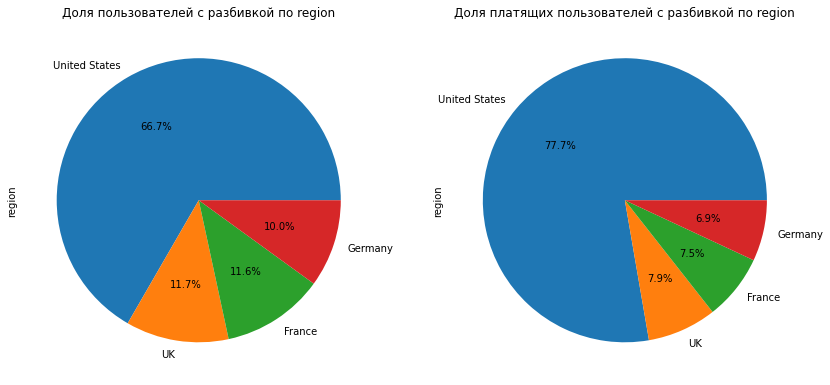

In [ ]:
plot_info(profiles, 'region')

Таблица и графики показывают, что в датафрейме представлена информация о пользователях из 4 стран: США, Великобритании, Франции и Германии.

Наибольшей долю на рынке имеют пользователи из США - ***66.7%*** среди всех пользователей и ***77.7%*** среди платящих пользователей.
Также пользователи из США обладают наибольшей конверсией в платящих пользователей ***6.9%***.

Пользователи из Великобритании и Франции имеют практически одинаковые результаты: доля пользователей чуть больше ***11.5%*** у каждой из стран. Доля платящих пользователей немного выше у Великобритании: ***7.9%*** против ***7.5%*** у Франции. Конверсия также немного больше у Великобритании - практически ***4%***, у Франции немногим меньше ***3.8%***.

Далее идет Германия: ***10%*** от общего количества пользователей и 6.9% от количества платящих пользователей. Однако, конверсия чуть выше чем у Великобритании и Франции - ***4.1%***.

**Учитывая наилучшую конверсию среди европейских стран, а также тот факт, что население Германии (83.1 миллиона в 2019 г.) больше населения Великобритании (66.8 миллиона в 2019 г.) и Франции (67.4 миллиона в 2019 г.), стоит обратить отдельное внимание на развитие немецкого рынка.**

### Анализ пользователей в разрезе девайсов

In [ ]:
info_about_device = info_table(profiles, 'device')
info_about_device

,users,payers,proportion
iPhone,54479,3382,0.06
Android,35032,2050,0.06
PC,30455,1912,0.06
Mac,30042,1537,0.05


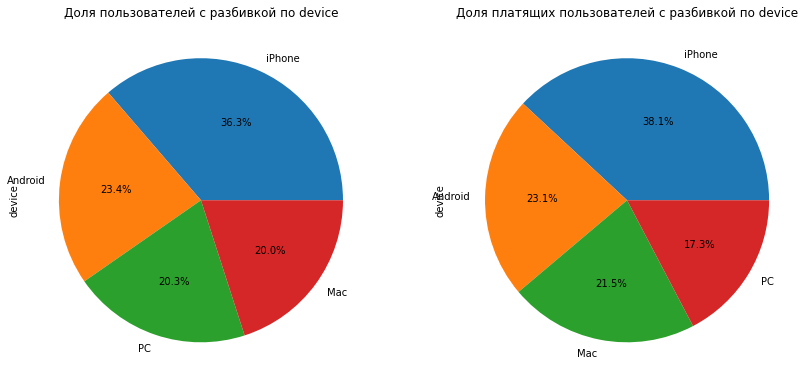

In [ ]:
plot_info(profiles, 'device')

У нас имеются данные о четырех платформах: **iPhone, Android, PC и Mac**.
Iphone занимает лидирующую позицию - ***36.3%*** от всех пользователей и ***38.1%*** среди платящих пользователей, конверсия в платящих пользователей составляет ***6.2%***.
Самой большой конверсией обладает РС - почти ***6.3%***. При этом доля на рынке у данной платформы не самая лучшая - ***20.3%*** пользователей и ***17.3%*** платящих пользователей. Стоит выяснить причину высокой конверсии у данных пользователей, с целью возможного применения наилучших решений на других платформах.
Далее идет Android - ***23.4%*** пользователей и ***23.1%*** платящих пользователей при конверсии ***5.8%***.
Замыкает четверку Мас с ***20%*** частью от всех пользователей, ***21.5%*** платящих пользователей и худшей конверсией - ***5.1%***.
Пользователи айфонов в настоящий момент являются ключевой категорией с наибольшей долей среди всех и только платящих пользователей и с одной из самых больших конверсий.

### Анализ пользователей в разрезе каналов привлечения

In [ ]:
info_about_channel = info_table(profiles, 'channel')
info_about_channel

,users,payers,proportion
organic,56439,3557,0.12
FaceBoom,29144,1878,0.11
TipTop,19561,1160,0.10
OppleCreativeMedia,8605,453,0.10
WahooNetBanner,8553,440,0.08
LeapBob,8553,352,0.05
RocketSuperAds,4448,262,0.04
MediaTornado,4364,233,0.04
YRabbit,4312,225,0.03
AdNonSense,3880,165,0.03


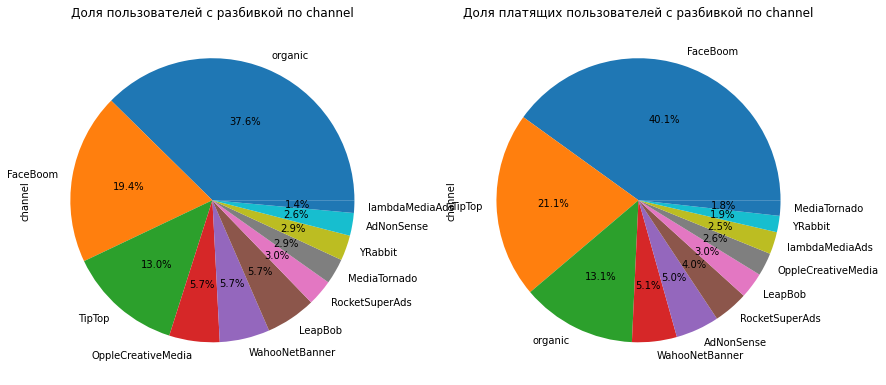

In [ ]:
plot_info(profiles, 'channel')

Мы видим 11 источников привлечения, причем самая большая доля у пользователей, пришедших на сайт самостоятельно. Это говорит о неэффективной маркетинговой стратегии.

Из рекламных источников только 2 привлекли более 10% пользователей, 8 оставшихся в сумме дают немногим более 20% от общего объема пользователей и такую же долю платящих пользователей. Также практически у всех рекламных источников конверсия в платящих пользователей ниже чем у пользователей, пришедших самостоятельно. Только у FaceBoom и lambdaMediaAds конверсия выше, чем у "органиков" - 6.4% и 7.2% против 6.3%.

Целесообразно определить 2-3 наиболее эффективных источника привлечения пользователей и перенаправить средства на них.

Также тот факт, что наибольшее количество пользователей нашли приложение самостоятельно говорит о том, что все источники бьют мимо целевой аудитории.

## Маркетинг

### Расчет общей суммы расходов на маркетинг

In [ ]:
costs['costs'].sum().round(2)

105497.3

Общая сумма на расходы составила 105497.3 у.е. Учитывая, что компания работает с американским и европейским рынками, можно предположить, что речь идет о долларах или евро. В любом случае на маркетинг потрачена внушительная сумма.

### Расчет расходов на маркетинг с разбивкой по источникам

In [ ]:
costs.groupby('channel').agg({'costs':'sum'})

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


Мы видим, что самыми затратными источниками стали FaceBoom и TipTop - 32445.6 и 54751.3 у.е. соответственно. Отдельно стоит обратить внимание, что источник TipTop при вложении более половины маркетингового бюджета уступает по доле привлеченных пользователей "органике" и FaceBoom, а по конверсии в платящих пользователей - "органике", FaceBoom и lambdaMediaAds. Данный источник является крайне неэффективным и при этом очень дорогим.

Рассмторим понедельную и помесячную динамику затрат на маркетинг в разбивке по источникам.

In [ ]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].astype('datetime64[M]')

In [ ]:
def ad_costs_count(df, time_interval):
    (
        df.pivot_table(index='channel', 
                   columns=time_interval, 
                   values='costs', 
                   aggfunc='sum')
        .T.plot(kind='line', 
                grid=True, 
                figsize=(18,10),
                title=f'Динамика затрат на маркетинг с разбивкой по каналам, интервал {time_interval}')
               );

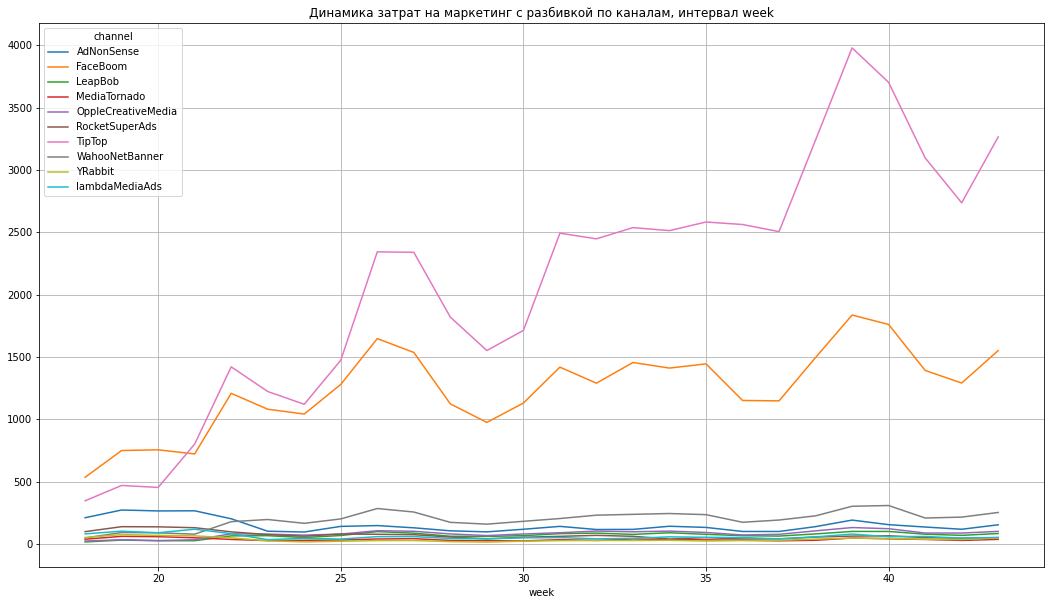

In [ ]:
ad_costs_count(costs, 'week')

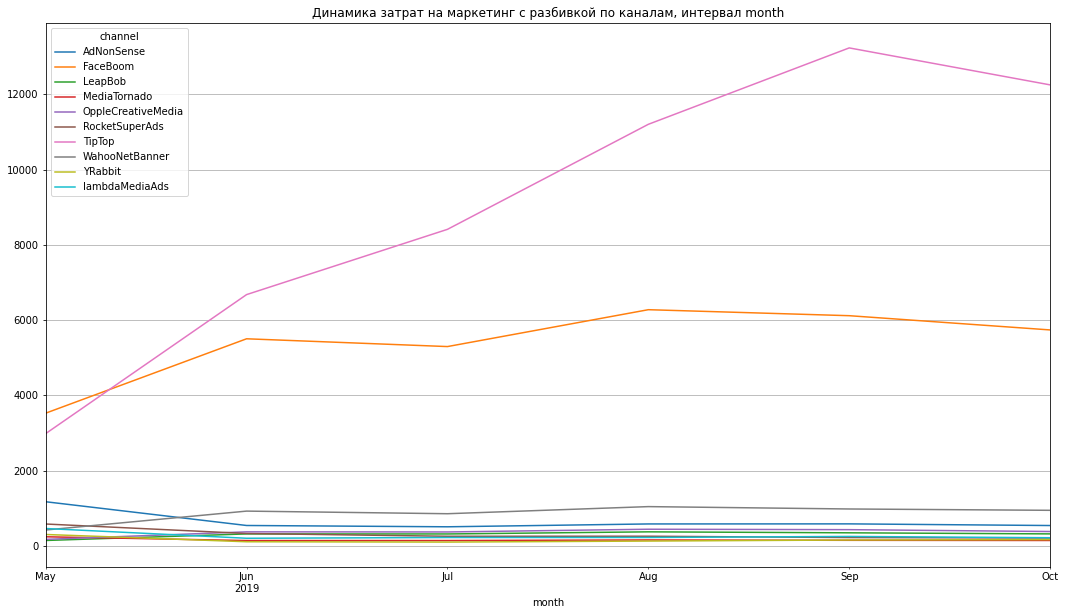

In [ ]:
ad_costs_count(costs, 'month')

Мы видим, что по основной массе источников вложения стабильно невысокие. Исключением являются FaceBoom и TipTop.
В них на протяжении всего времени вкладывались значительно большие средства. При этом если расходы на FaceBoom стабилизировались примерно на уровне 6000 у.е., то расходы на TipTop росли на протяжении всего анализируемого периода, только ближе к октябрю произошло заметное снижение.

### Расчет САС для каждого пользователя.

In [ ]:
def get_sas(profiles, ad_costs):
    new_users = (
    profiles.groupby(['dt', 'channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_users'})
    .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [ ]:
profiles = get_sas(profiles, costs)

In [ ]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.50
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.00
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.60
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.21


In [ ]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop               2.80
FaceBoom             1.11
AdNonSense           1.01
lambdaMediaAds       0.72
WahooNetBanner       0.60
RocketSuperAds       0.41
OppleCreativeMedia   0.25
YRabbit              0.22
MediaTornado         0.22
LeapBob              0.21
organic              0.00
Name: acquisition_cost, dtype: float64

Самые дорогие пользователи ожидаемо в источнике TipTop - 2.79 у.е., дальше с большим отрывом идут FaceBoom и AdNonSense - 1.11 и 1 у.е. соответственно. У всех остальынх источников стоимость привлечения от 0.72 у.е и ниже. Естественно "органики" пришли бесплатно.

## Оценка окупаемости рекламы

Так как речь идет об оценке рекламы, будем рассматривать только пользователей пришедших через рекламу.

In [ ]:
non_org_profiles = profiles.query('channel != "organic"')
non_org_profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.01
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.90
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.12
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.50
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.60


### Графики LTV и ROI и графики динамики LTV, CAC и ROI

Для начала рассчитаем LTV, средний САС и ROI. САС для каждого пользователя у нас уже есть в профилях клиентов в поле `acquisition_cost`. Изначально оценим ситуацию в общем, без каких-либо дополнительных параметров для категорирования результатов. Используем для этого формулу **`get_ltv`**.

Выведем на экран получившиеся LTV и ROI.

In [ ]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(non_org_profiles, orders, datetime(2019, 11, 1).date(), 14)

In [ ]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.35,0.44,0.50,0.56,0.61,0.65,0.69,0.73,0.76,0.80,0.83,0.85,0.88,0.90


In [ ]:
roi

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All users,88644,1.12,0.31,0.39,0.45,0.50,0.55,0.59,0.62,0.65,0.68,0.71,0.74,0.76,0.79,0.81


Мы видим, что количество пользователей в общей и единственной когорте меньше, чем количество профилей в датафрейме с пользователями, пришедшими по рекламным источникам. Это связано с тем, что выбранный нами горизонт анализа "отсекает" часть пользователей, привлеченных позднее максимально подходящей даты, так как у всех пользователей должно набраться 14 лайфтаймов.

Также мы видим, что LTV и ROI постепенно растут, что соответствует стандартному поведению данных метрик.

Средний САС для всех пользователей, попавших в анализ равен ~ 1.11 у.е.
При текущим уровне САС окупаемость клиентов к 14 дню равно лишь 80%.

Теперь из имеющихся датафреймов мы можем построить интересующие нас графика для формирования более подробных выводов.

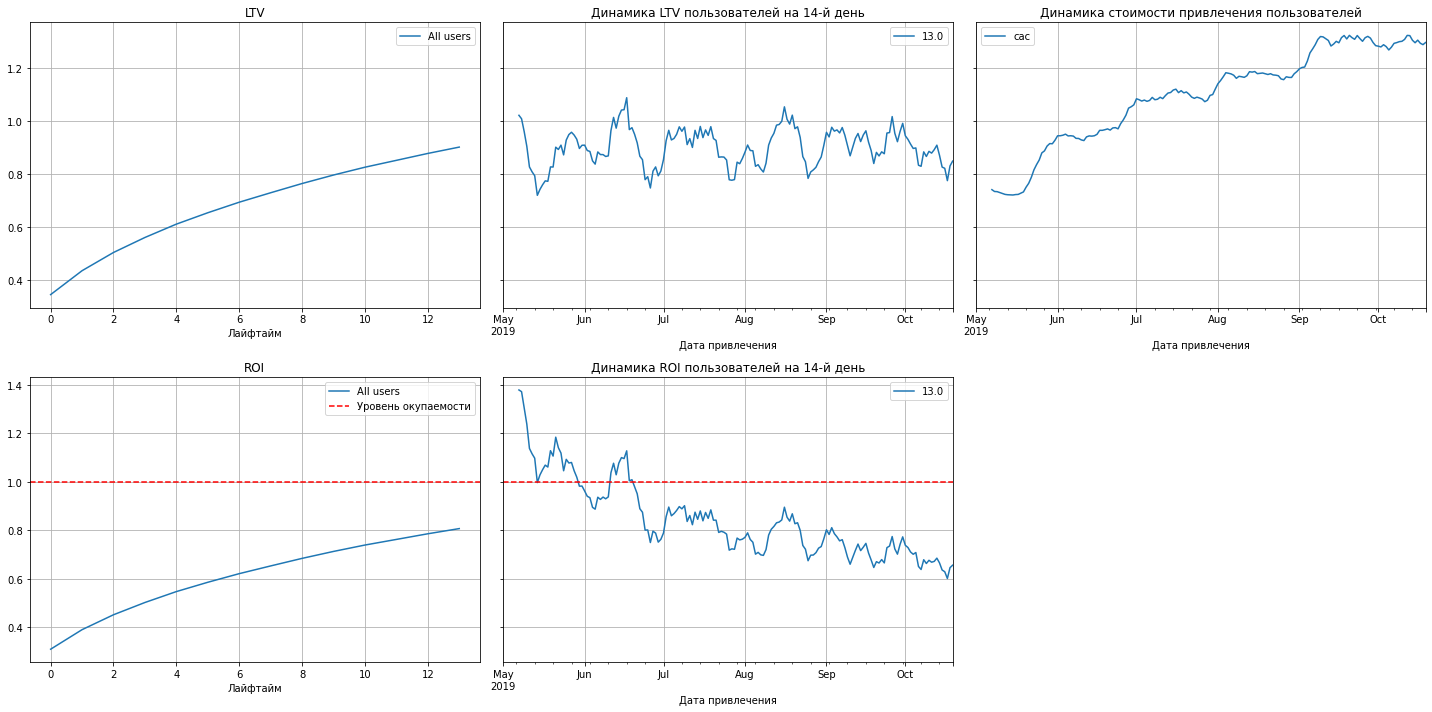

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon=14, window=7)

Из получившихся графиков мы видим, что график LTV пользователей имеет стандартную форму и к 14-му дню равняется 0.8 у.е. Динамика LTV пользователей на 14 день на протяжении всего периода исследования колеблится в диапазоне от 0.8 до 1 у.е.

Динамика стомости привлечения пользователей стабильно росла на протяжении почти всего периода исследования, достигнув максимума к сентябрю, и затем держалась на этом уровне. Уже можно сделать первый вывод, что увеличение затрат на маркетинг не привело к увеличению прибыли, приносимой отдельно взятым пользователем.

График ROI демонстрирует стандартное поведение и к 14-му дню достигает значений, равных окупаемости 80%.

График динамики ROI 14-го дня показывает интересные результаты: в начале исследуемого периода он был равен 140%, после чего достаточно резко опустился до 100%, продержался на этом уровне до середины июня и затем начал постепенное снижение до уровня 65% ко второй половине октября.

**Как мы видим, в начале исследуемого периода окупаемости компании была на достаточно высоком уровне, но затем начала резко снижаться. Необходимо выяснить, что могло привести к этому. Можно предположить следующие основные гипотезы:**

1. Пожизненная ценность оставалась на одном уровне, но снизилось количество платящих пользователей. Для этого надо рассмотреть динамику Retention rate и Conversion rate.
2. Выросли расходы, а доходы остались на том же уровне. То есть реклама стала отнимать много средств, но не дает соответствующей отдачи.

### Конверсия пользователей

In [ ]:
raw_c, conversion, conversion_history = get_conversion(non_org_profiles, orders, datetime(2019,11,1).date(), 14)

In [ ]:
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.06,0.07,0.07,0.07,0.07,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08


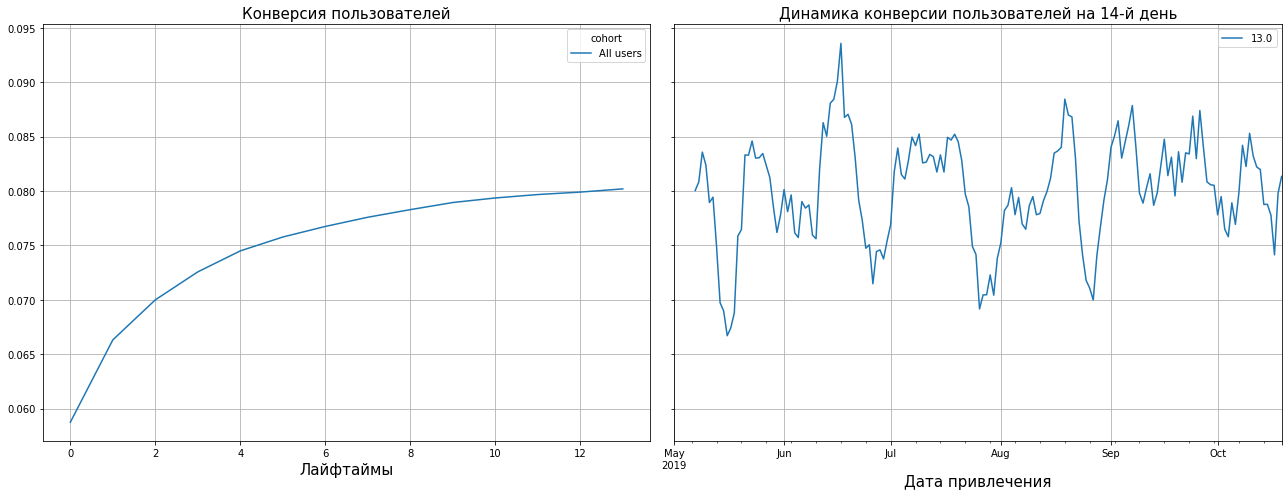

In [ ]:
plot_conversion(conversion, conversion_history, horizon=14, window=7)

График конверсии имеет стандартную форму и достигает значения 8% на 14-й день.

Динамика конверсии пользователей в платящих пользователей на 14-й достаточно нестабилен, несмотря на сглаживание значений. Видно 4 резких провала, когда конверсия проваливалась на 1% и даже более, а затем достаточно быстро восстанвливалась. То есть по какой-то причине пользователи резко переставали делать покупки, а потом также резко снова начинали оплачивать приложение. Однако, можно заметить, что начиная с начала сентября провалы в конверсии прекратились. Из имеющихся сложно установить, в чем была причина весенне-летних провалов, но вероятно, что она была устранена.

**Несмотря на то, что конверсия пользователей демонстрирует нестабильность, в целом она держится на одном уровне и даже не имеет провалов на интервале с сентября до середины октября. Так что маловероятно, что падение окупаемости вызвано проблемами с конверсией пользователей.**

### Удержание пользователей

In [ ]:
raw_r, retention, retention_history = get_retention(non_org_profiles, visits, datetime(2019,11,1).date(), 14)

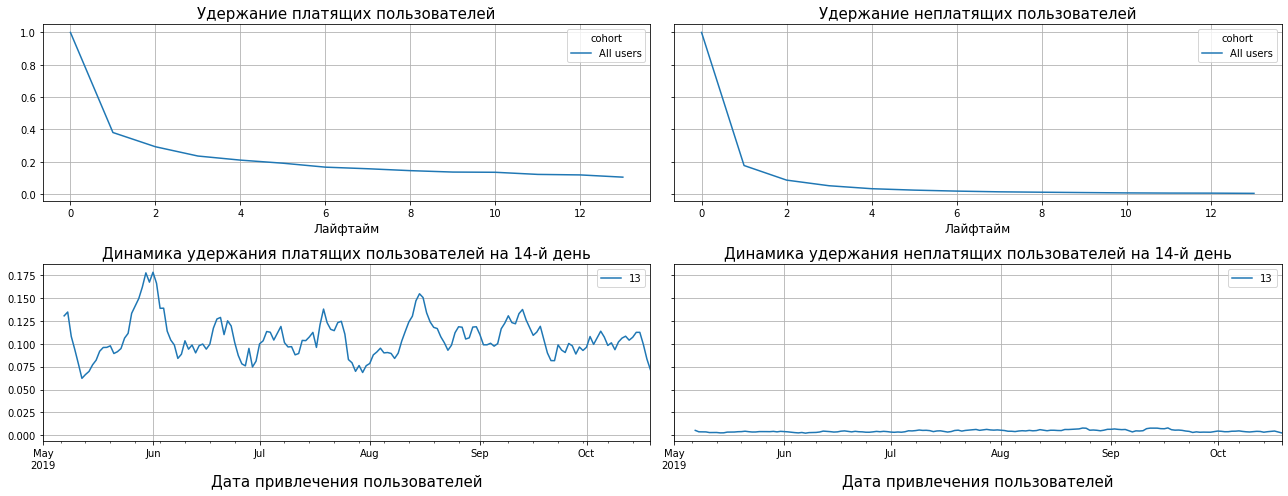

In [ ]:
plot_retention( retention, retention_history, horizon=14, window=7)

График удержания платящих пользователей показывает резкий провал в первый же лайфтайм, а затем постепенное снижение свойственное нормальному Retention Rate. 60% платящих пользователей уходят из приложения на следующий день после первого посещения.
Аналогичная ситуация с удержанием неплатящих пользователей, только в первый лайфтайм уходят уже 80% пользователей, а после 8-го лайфтайма фактически никого не остается.
График динамики конверсии на 14-й день колеблется в диапазоне от 7.5% до 17.5%.

Динамика удержания неплатящих пользователей на 14-й день стабильно находится в районе 0.

**Поведение неплатящих пользователей говорит о том, что скорее всего приложение не может ничего предложить тем, кто не готов сразу заплатить за подписку, требуется некий пробный период, позволяющий продемонстрировать плюсы приложения.**

**Удержание платящих пользователей стабильно. Соответственно это не могло стать причиной падения окупаемости.**

### Окупаемость рекламы с разбивкой по устройствам

In [ ]:
raw, ltv_d, ltv_d_history, roi_d, roi_d_history = get_ltv(non_org_profiles, orders, datetime(2019,11,1).date(), 14, dimensions=['device'])

In [ ]:
ltv_d

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
Android,20683,0.34,0.43,0.50,0.56,0.61,0.66,0.70,0.74,0.77,0.81,0.83,0.86,0.89,0.91
Mac,17747,0.38,0.48,0.55,0.61,0.65,0.69,0.72,0.75,0.79,0.83,0.86,0.88,0.90,0.93
PC,18128,0.28,0.36,0.43,0.49,0.54,0.58,0.63,0.66,0.70,0.73,0.76,0.79,0.81,0.84
iPhone,32086,0.37,0.46,0.52,0.58,0.63,0.67,0.71,0.75,0.78,0.81,0.84,0.87,0.89,0.92


In [ ]:
roi_d

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,,
Android,20683,1.02,0.33,0.42,0.49,0.54,0.60,0.65,0.69,0.72,0.76,0.79,0.82,0.84,0.87,0.89
Mac,17747,1.28,0.30,0.38,0.43,0.47,0.51,0.54,0.57,0.59,0.62,0.65,0.67,0.69,0.71,0.73
PC,18128,0.79,0.35,0.46,0.54,0.61,0.68,0.73,0.80,0.84,0.88,0.92,0.96,0.99,1.02,1.05
iPhone,32086,1.28,0.29,0.36,0.41,0.46,0.50,0.53,0.56,0.59,0.61,0.64,0.66,0.68,0.70,0.72


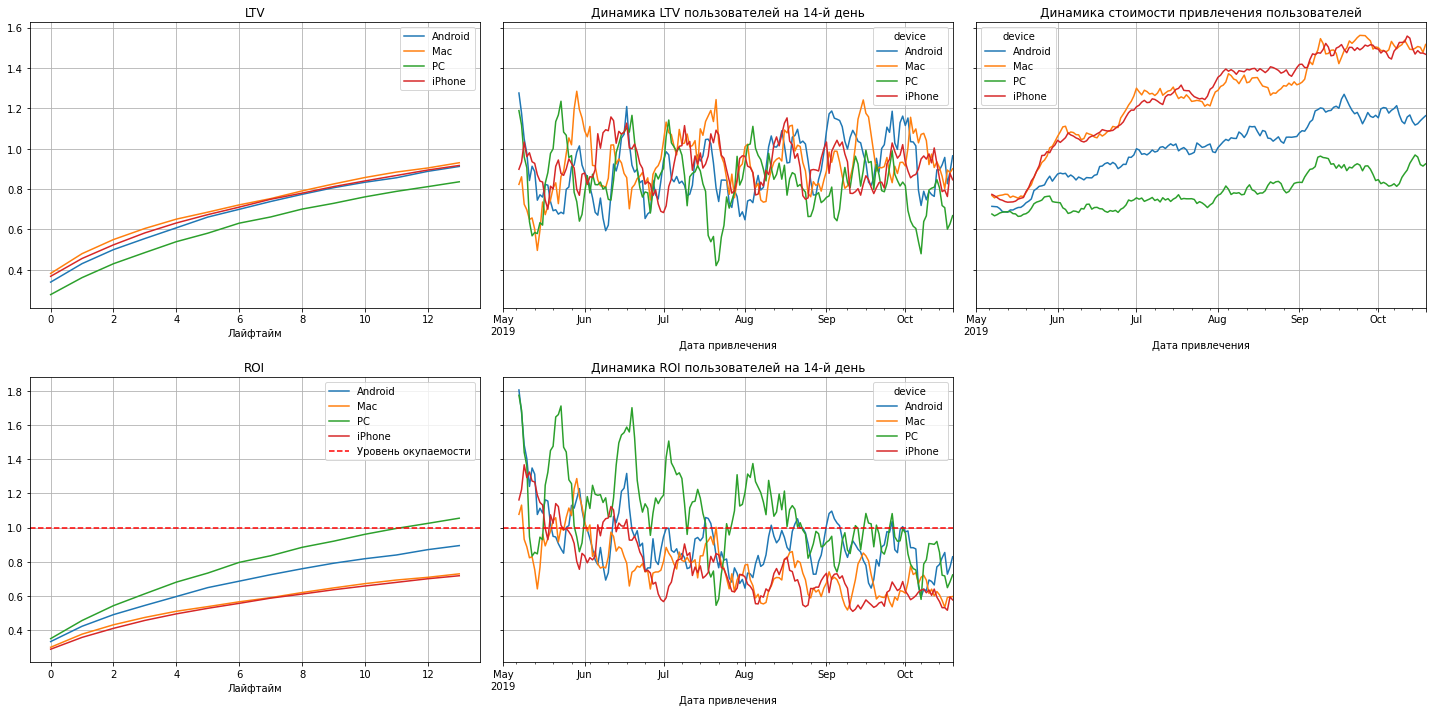

In [ ]:
plot_ltv_roi(ltv_d, ltv_d_history, roi_d, roi_d_history, 14, 7)

In [ ]:
def ltv_roi_14 (ltv, roi):
    df = ltv.merge(roi, how='left', left_index=True, right_index=True)[['13.0_x','13.0_y']]
    df.columns = ['ltv_on_14th_day', 'roi_on_14th_day']
    return df

In [ ]:
ltv_roi_14(ltv_d, roi_d)

,ltv_on_14th_day,roi_on_14th_day
device,,
Android,0.91,0.89
Mac,0.93,0.73
PC,0.84,1.05
iPhone,0.92,0.72


Кривая LTV показывает, что пользователи Android, Mac и iPhone имеют примерно одинаковую пожизненную ценность на уровне чуть выше 0.9 у.е. Пользователи РС отстают от остальных девайсов со значением 0.83 у.е.

Динамика LTV показывает, что данная метрика крайне нестабильная для всех девайсов, даже со сглаживанием равным 14 график тяжело читать: мы имеем "кашу" из линий в диапазоне от 0.8 до 1 у.е. Но даже тут видно, что LTV пользователей РС, привлеченных в конце июля, начале сентября и начале октября по какой-то причине имеет провалы. С этим скорее всего и связан тот факт, что LTV РС-пользователей в целом ниже, чем у пользователей остальных девайсов.

Динамика стоимости привлечения пользователей показывает, что самым дешевым на протяжении всего периода времени было привлечение пользователей РС, причем за все время оно подорожало меньше всех (около 0.15 у.е. за все время), а среднее значение составило 0.8 у.е. Далее идет стоимость привлечения пользователей Android: изначально оно стоило примерно столько же, сколько и привлечение РС-пользователей, но с течением времени подорожало до 1.2 у.е., среднее значение 1.01 у.е.

Наиболее дорогим оказалось привлечение пользователей Мас и iPhone: в среднем 1.27 у.е., они также подорожали сильнее всех и осенью стоимость достигала уже 1.5 у.е. - почти в два раза дороже привлечения пользователей РС. При этом, если доля пользователей айфонов является самой большой, то пользователи Мас - самая малочисленная группа пользователей.

График ROI является в каком-то смысле зеркальным отражением графика CAC: наверху оказывается РС с окупаемостью 105% на 14-й день (это при том, что LTV у пользователей PC самый низкий!), далее идет Android с окупаемостью 89% на 14-й день, а внизу оказались Мас и iPhone с окупаемостью 71-72%.

Динамика ROI демонмтрирует планомерное снижение по всем четырем девайсам, хотя значения РС выделяются: вплоть до середины августа они держались на уровне 120% (за исключением кратковременного провала в конце июля), а потом поддались общему тренду на снижение.

**Данные результаты подтверждают вывод о том, что увеличение затрат на рекламу не привело к увеличению выручки, но стало причиной отсутствия прибыли.**

**Отдельно стоит обратить внимание на пользователей РС. При наименьших расходах на рекламу они демонмтрируют сравнимую пожизненную ценность и единственные демонстрируют окупаемость.**

**Также необходимо рассмотреть пользователей iPhone. Данная группа является самой многочисленной, поэтому при доработке приложения с целью повышения конверсии необходимо в первую очередь работать с приложением на iPhine.**

### Окупаемость рекламы с разбивкой по странам

In [ ]:
raw, ltv_r, ltv_r_history, roi_r, roi_r_history = get_ltv(non_org_profiles, orders, datetime(2019,11,1).date(), 14, dimensions=['region'])

In [ ]:
ltv_r

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.19,0.26,0.31,0.36,0.41,0.45,0.48,0.51,0.54,0.57,0.60,0.62,0.65,0.67
Germany,9030,0.19,0.26,0.33,0.38,0.42,0.46,0.50,0.53,0.57,0.61,0.64,0.67,0.69,0.71
UK,10536,0.22,0.30,0.37,0.42,0.47,0.50,0.56,0.59,0.62,0.65,0.67,0.69,0.72,0.74
United States,58562,0.42,0.52,0.59,0.65,0.70,0.75,0.79,0.83,0.86,0.89,0.92,0.95,0.98,1.00


In [ ]:
roi_r

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,,
France,10516,0.46,0.42,0.56,0.68,0.78,0.88,0.98,1.05,1.10,1.18,1.24,1.30,1.35,1.41,1.46
Germany,9030,0.46,0.40,0.56,0.71,0.81,0.91,0.99,1.07,1.15,1.23,1.30,1.38,1.43,1.49,1.53
UK,10536,0.45,0.48,0.65,0.81,0.92,1.02,1.11,1.22,1.29,1.37,1.42,1.47,1.52,1.58,1.63
United States,58562,1.46,0.29,0.36,0.41,0.45,0.48,0.51,0.54,0.57,0.59,0.61,0.63,0.65,0.67,0.69


In [ ]:
ltv_roi_14(ltv_r, roi_r)

,ltv_on_14th_day,roi_on_14th_day
region,,
France,0.67,1.46
Germany,0.71,1.53
UK,0.74,1.63
United States,1.00,0.69


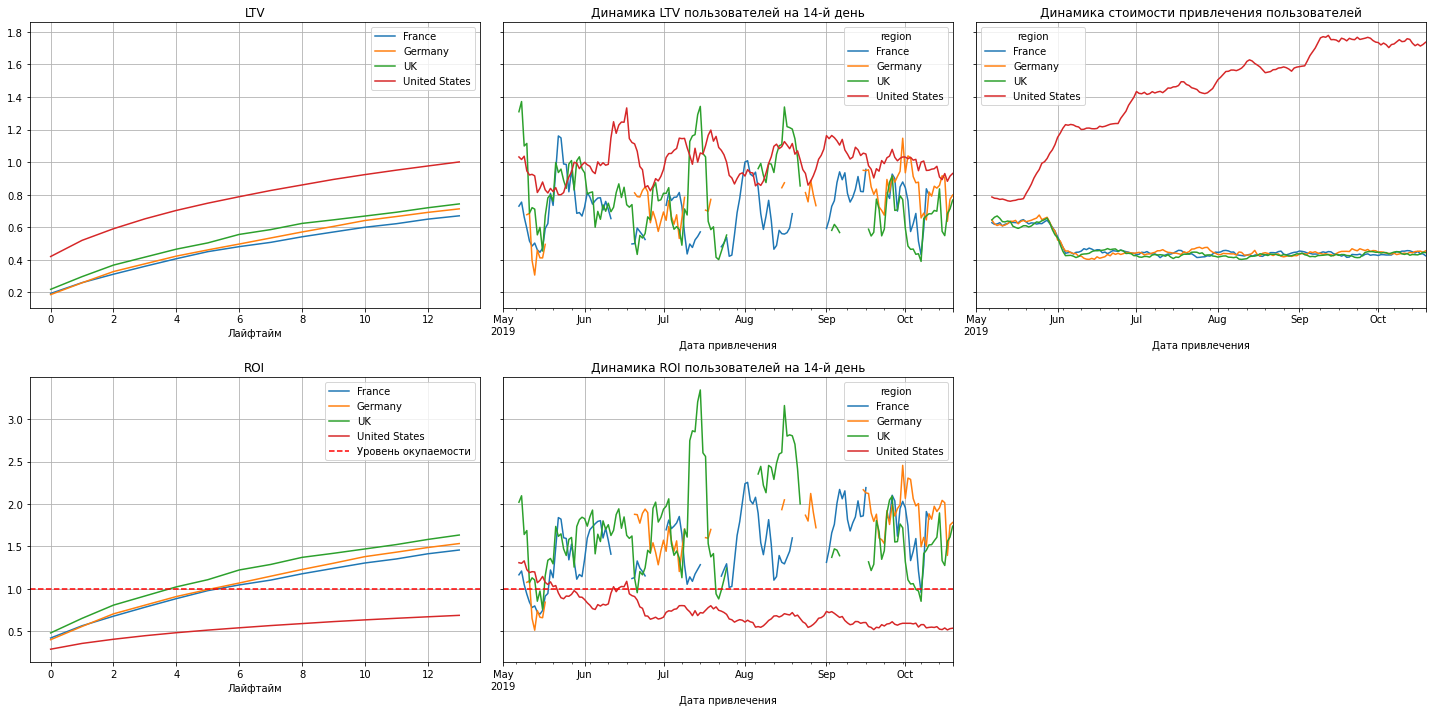

In [ ]:
plot_ltv_roi(ltv_r, ltv_r_history, roi_r, roi_r_history, 14, 7)

Кривая LTV демонстрирует значительное преимщуество США перед другими странами: 1 у.е. у штатов и около 0.7 у.е у остальных стран.

Динамика на LTV на 14-й день демонстрирует, что графики европейских стран прерывистые - это говорит о том, что в какие-то моменты не было ни одного пользователя оттуда. Учитывая, что количество пользователей измеряется десятками тысяч, такого не может быть. Скорее всего возникали какие-то сбои в работе приложения в этих странах. Разрывы на графиках динамики LTV совпадает с провалами на графике конверсии, что вполне логично: если пользователь не может воспользоваться приложением, то он его не оплатит.

Динамика стоимости привлечения пользователей демонстрирует нам, что скорее всего в конце мая было принято решение резко увеличить привлечение американских пользователей, в том числе за счет бюджетов на рекламу на европейском рынке. Скорее всего это было сделано на основе LTV по состоянию на середину мая: в тот момент на европейском рынке был спад, за счет которого американский рынок выглядел более привлекательным (0.8 у.е в США и не более 0.5 у.е. у европейских стран). Провалы в выручке от европейских стран, вызванные сбоем приложения только убеждали, что европейский рынок бесперспективен. Однако, увеличение вложений в рекламу в США не привело к увеличению выручки в этом регионе. Либо реклама была направлена не на ту аудиторию, либо приложение полностью заняло, имевшуюся свободную нишу, за пределы которой не получается выйти по тем или иным причинам( например конкуренты).

Увеличение затрат на рекламу без увеличения выручки в США негативно сказалось на окупаемости пользователей оттуда - всего около 70%. Важно отметить, что даже до принятия решения о перераспределении маркетинговых расходов окупаемость пользователей из США была самой низкой.

График динамики ROI также показывает разрывы для европейских пользователей, вызванных возможным сбоем в работе приложения. И даже, несмотря на наличие сбоев, окупаемость находится на уровне 140-160% в зависимости от страны - впечатляющие цифры. Окупаемость же пользователей из США на 14-й день составляет всего около 70%, однако за счет того, что доля пользователей из США составляет 70% от общего объема пользователей, то они "утянули" общую окупаемость за собой ниже 100%.

Можно сделать вывод, что ставка на американский рынок в погоне за количеством пользователей, и связанные с этим вложения в рекламу в США повлекли за собой убытки компании. Также негативную роль сыграла нестабильная работа приложения в прибыльном европейском регионе.

### Окупаемость рекламы с разбивкой по источникам

In [ ]:

raw, ltv_c, ltv_c_history, roi_c, roi_c_history = get_ltv(non_org_profiles, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])

In [ ]:
ltv_c

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.51,0.59,0.64,0.68,0.71,0.73,0.75,0.77,0.79,0.80,0.81,0.82,0.83,0.84
FaceBoom,27544,0.59,0.66,0.70,0.73,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.81,0.82,0.82
LeapBob,8103,0.11,0.16,0.21,0.24,0.26,0.29,0.31,0.33,0.37,0.39,0.42,0.44,0.46,0.47
MediaTornado,4167,0.14,0.19,0.25,0.29,0.33,0.37,0.39,0.42,0.44,0.46,0.49,0.51,0.53,0.53
OppleCreativeMedia,8139,0.10,0.13,0.17,0.21,0.24,0.27,0.29,0.31,0.33,0.35,0.36,0.38,0.40,0.41
RocketSuperAds,4251,0.21,0.32,0.40,0.46,0.52,0.57,0.64,0.69,0.74,0.79,0.83,0.86,0.90,0.93
TipTop,18498,0.34,0.50,0.62,0.74,0.84,0.94,1.01,1.10,1.17,1.25,1.31,1.37,1.43,1.49
WahooNetBanner,8082,0.19,0.29,0.38,0.44,0.52,0.57,0.63,0.68,0.73,0.77,0.81,0.85,0.89,0.92
YRabbit,4102,0.16,0.21,0.26,0.30,0.36,0.39,0.41,0.44,0.46,0.48,0.50,0.52,0.55,0.56


In [ ]:
roi_c

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
AdNonSense,3702,1.01,0.50,0.58,0.64,0.68,0.70,0.73,0.75,0.76,0.78,0.80,0.80,0.81,0.82,0.83
FaceBoom,27544,1.11,0.53,0.59,0.63,0.65,0.67,0.68,0.70,0.70,0.71,0.72,0.72,0.73,0.73,0.74
LeapBob,8103,0.21,0.51,0.74,0.98,1.12,1.24,1.37,1.50,1.59,1.76,1.88,1.99,2.09,2.18,2.25
MediaTornado,4167,0.22,0.63,0.87,1.13,1.34,1.52,1.68,1.77,1.91,2.01,2.11,2.22,2.32,2.40,2.44
OppleCreativeMedia,8139,0.25,0.39,0.53,0.69,0.83,0.96,1.07,1.16,1.24,1.31,1.39,1.46,1.51,1.58,1.64
RocketSuperAds,4251,0.42,0.50,0.76,0.95,1.09,1.24,1.37,1.53,1.65,1.77,1.89,1.99,2.07,2.15,2.24
TipTop,18498,2.76,0.12,0.18,0.23,0.27,0.31,0.34,0.37,0.40,0.42,0.45,0.48,0.50,0.52,0.54
WahooNetBanner,8082,0.60,0.32,0.48,0.63,0.74,0.86,0.95,1.05,1.13,1.21,1.27,1.35,1.41,1.48,1.53
YRabbit,4102,0.22,0.75,0.98,1.18,1.40,1.64,1.79,1.91,2.02,2.12,2.21,2.31,2.41,2.52,2.58


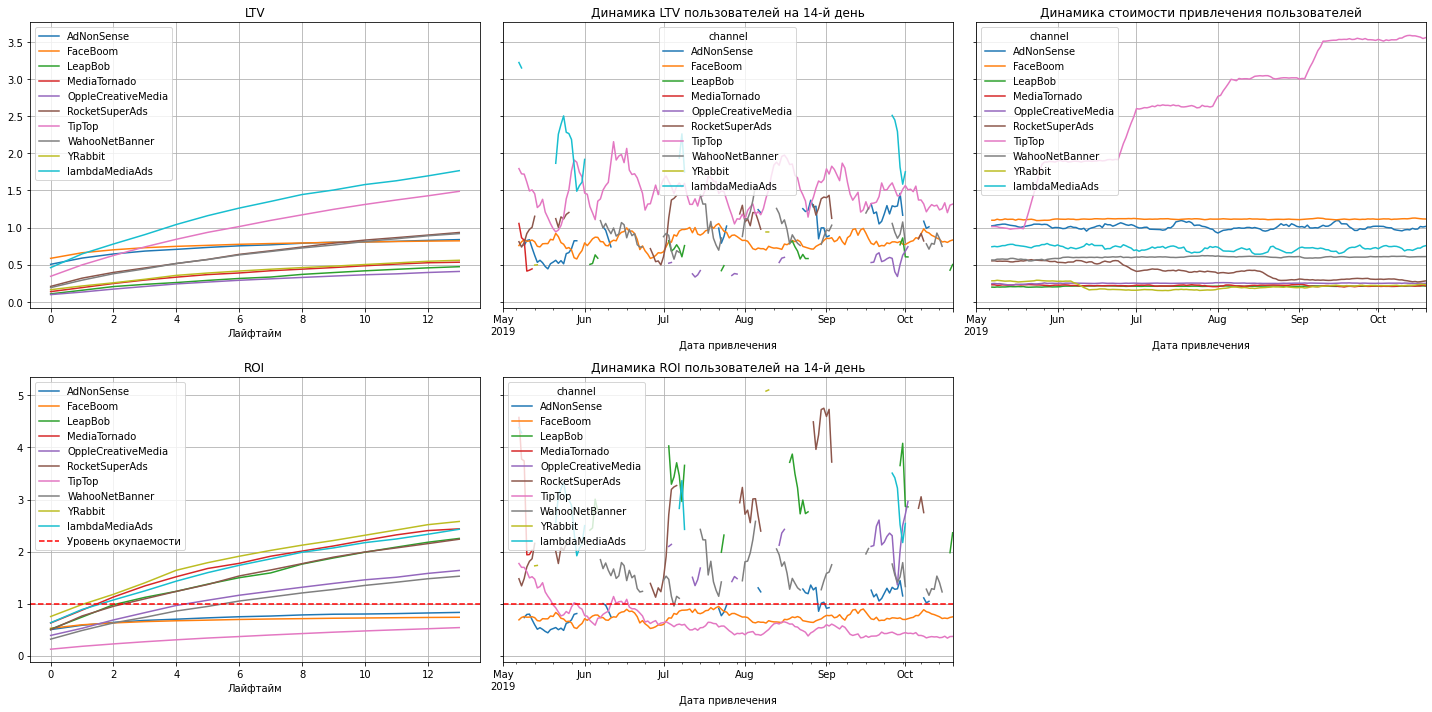

In [ ]:
plot_ltv_roi(ltv_c, ltv_c_history, roi_c, roi_c_history, 14, 7)

Графики динамики LTV и ROI получились с большим количеством разрывов и по ним сложно делать выводы, однако по графику САС мы видим, что на протяжении всего периода вложения в большинство каналов оставались на одном уровне, исключениями являются только TipTop и RocketSuperAds. Вложения в TipTop стремительно росли на протяжении всего периода, а вложения RocketSuperAds постепенно снижались.

Из графика ROI мы видим, что TipTop имеет самую низкую окупаемость, так что смело можно делать вывод, что вложения не окупились.

### Дополнительные расчеты конверсии и удержания

#### Конверсия по девайсам

In [ ]:
raw_d, conversion_d, conversion_d_history = get_conversion(non_org_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

In [ ]:
conversion_d

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
Android,20683,0.06,0.07,0.07,0.07,0.07,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
Mac,17747,0.06,0.07,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.09,0.09,0.09,0.09,0.09
PC,18128,0.05,0.05,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.07
iPhone,32086,0.06,0.07,0.07,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08


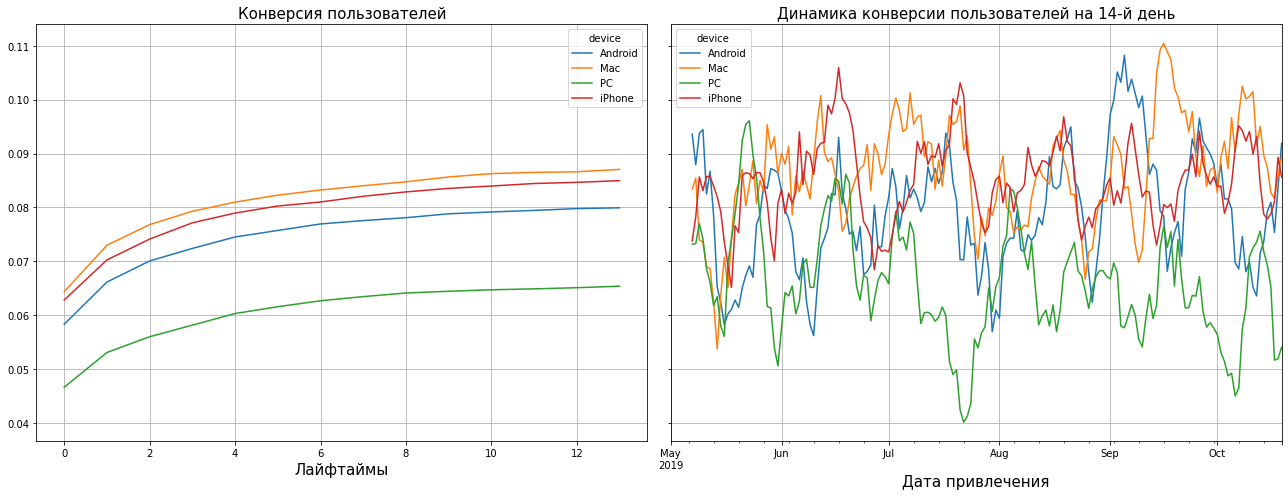

In [ ]:
plot_conversion(conversion_d, conversion_d_history, 14, 7)

#### Удержание по девайсам

In [ ]:
raw_d, retention_d, retention_d_history = get_retention(non_org_profiles, visits, datetime(2019,11,1).date(), 14, dimensions=['device'])

In [ ]:
retention_d

cohort_size    0    1    2    3    4    5    6    7    8    9  \
payer device                                                                   
False Android        18988 1.00 0.17 0.09 0.05 0.03 0.02 0.02 0.01 0.01 0.01   
      Mac            16150 1.00 0.18 0.09 0.05 0.03 0.02 0.02 0.01 0.01 0.01   
      PC             16920 1.00 0.17 0.09 0.05 0.03 0.02 0.02 0.01 0.01 0.01   
      iPhone         29276 1.00 0.18 0.09 0.05 0.03 0.03 0.02 0.01 0.01 0.01   
True  Android         1695 1.00 0.38 0.30 0.25 0.21 0.21 0.16 0.17 0.15 0.14   
      Mac             1597 1.00 0.37 0.28 0.20 0.20 0.17 0.15 0.14 0.14 0.13   
      PC              1208 1.00 0.42 0.33 0.26 0.26 0.21 0.23 0.19 0.18 0.15   
      iPhone          2810 1.00 0.37 0.28 0.23 0.19 0.19 0.16 0.14 0.14 0.13   

                10   11   12   13  
payer device                       
False Android 0.01 0.01 0.01 0.01  
      Mac     0.01 0.01 0.01 0.00  
      PC      0.01 0.01 0.01 0.01  
      iPhone  0.01 0.01 0.01 0.00  
True  Android 0.13 0.11 0.13 0.11  
      Mac     0.12 0.12 0.11 0.11  
      PC      0.16 0.15 0.14 0.12  
      iPhone  0.13 0.12 0.11 0.09

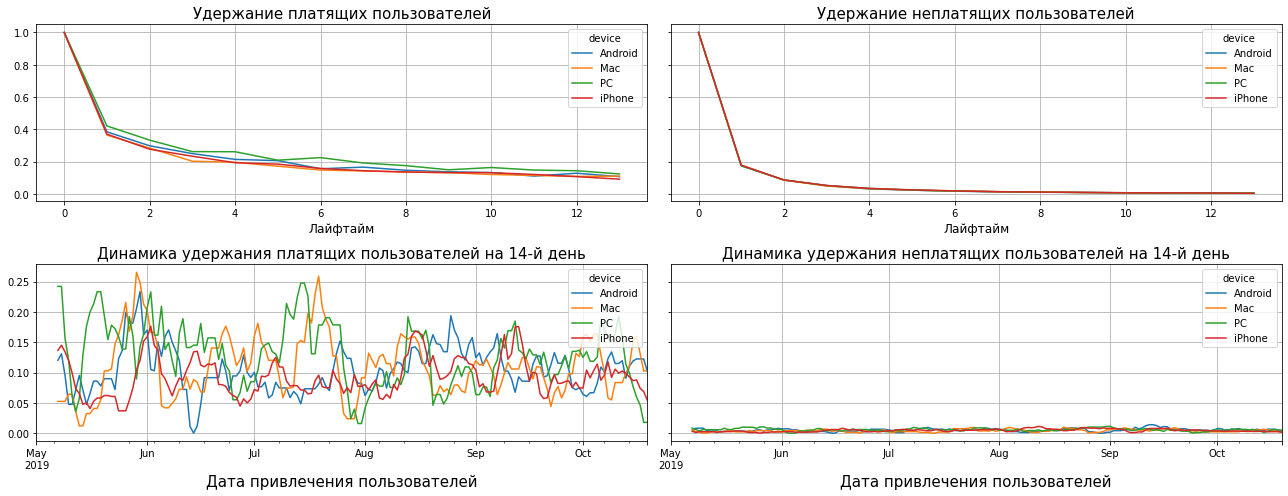

In [ ]:
plot_retention(retention_d, retention_d_history, 14,7)

#### Конверсия по странам

In [ ]:
raw_r, conversion_r, conversion_r_history = get_conversion(non_org_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

In [ ]:
conversion_r

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.03,0.04,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
Germany,9030,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
UK,10536,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
United States,58562,0.07,0.08,0.08,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.10,0.10,0.10,0.10


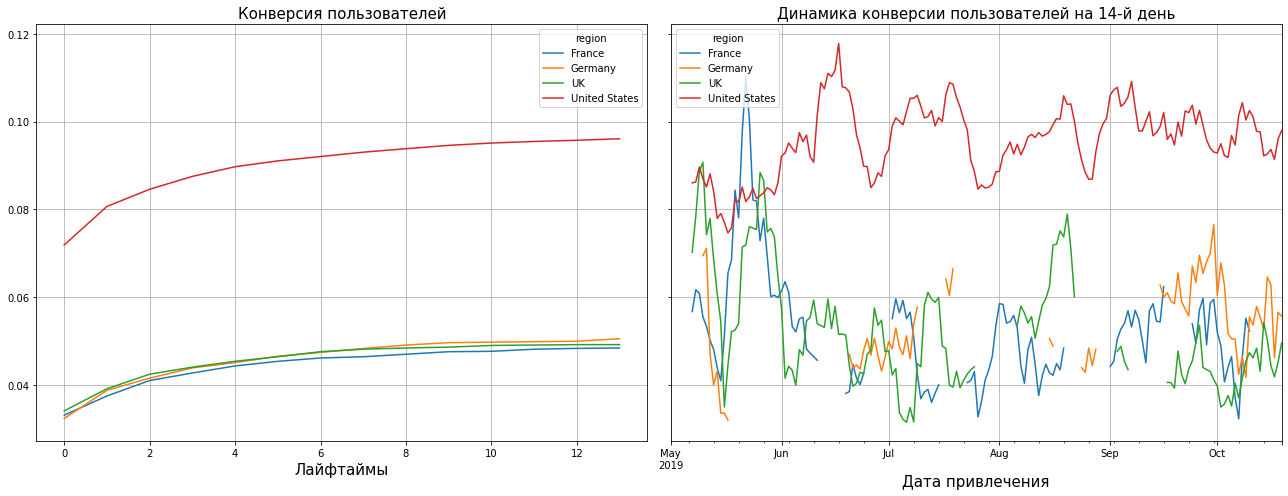

In [ ]:
plot_conversion(conversion_r, conversion_r_history, 14, 7)

#### Удержание по странам

In [ ]:
raw_r, retention_r, retention_r_history = get_retention(non_org_profiles, visits, datetime(2019,11,1).date(), 14, dimensions=['region'])

In [ ]:
retention_r

cohort_size    0    1    2    3    4    5    6    7    8  \
payer region                                                                    
False France                9993 1.00 0.17 0.09 0.05 0.03 0.02 0.02 0.01 0.01   
      Germany               8563 1.00 0.18 0.08 0.06 0.04 0.03 0.02 0.01 0.01   
      UK                   10002 1.00 0.18 0.09 0.05 0.03 0.02 0.02 0.02 0.01   
      United States        52776 1.00 0.18 0.09 0.05 0.03 0.03 0.02 0.01 0.01   
True  France                 523 1.00 0.47 0.39 0.32 0.31 0.30 0.25 0.24 0.22   
      Germany                467 1.00 0.48 0.40 0.31 0.33 0.28 0.24 0.22 0.24   
      UK                     534 1.00 0.48 0.42 0.33 0.30 0.28 0.27 0.25 0.20   
      United States         5786 1.00 0.35 0.26 0.21 0.18 0.17 0.14 0.14 0.13   

                       9   10   11   12   13  
payer region                                  
False France        0.01 0.01 0.01 0.01 0.01  
      Germany       0.01 0.01 0.01 0.01 0.01  
      UK            0.01 0.01 0.01 0.01 0.00  
      United States 0.01 0.01 0.01 0.01 0.00  
True  France        0.20 0.21 0.17 0.19 0.17  
      Germany       0.21 0.23 0.17 0.16 0.13  
      UK            0.16 0.17 0.19 0.18 0.18  
      United States 0.12 0.12 0.11 0.10 0.09

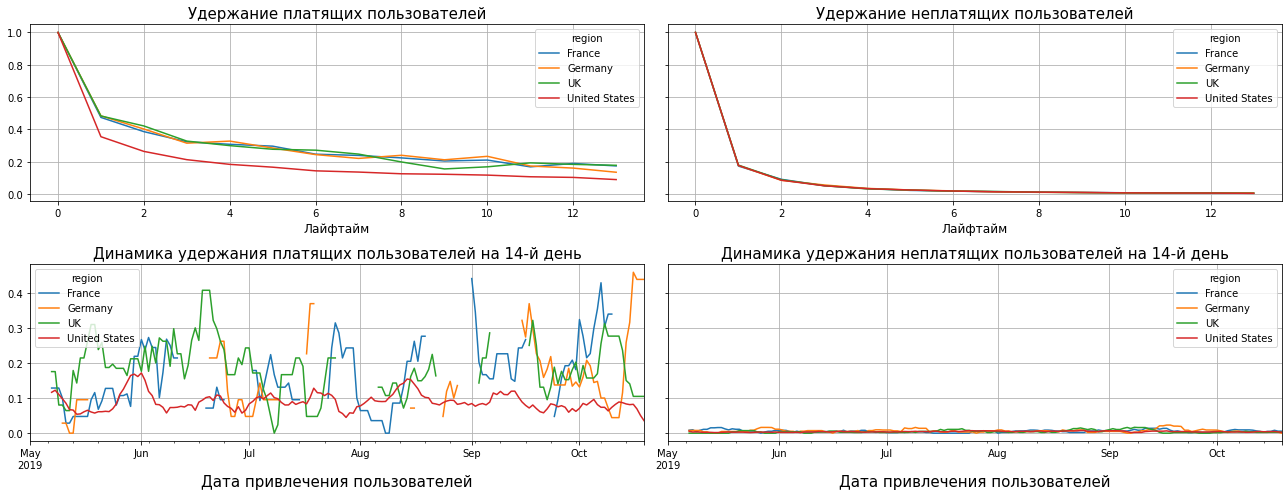

In [ ]:
plot_retention(retention_r, retention_r_history, 14,7)

#### Конверсия по каналам привлечения

In [ ]:
raw_с, conversion_с, conversion_с_history = get_conversion(non_org_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

In [ ]:
conversion_с.sort_values(by=13, ascending=False)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
FaceBoom,27544,0.10,0.11,0.11,0.11,0.11,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
AdNonSense,3702,0.09,0.09,0.10,0.10,0.10,0.10,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
lambdaMediaAds,2056,0.07,0.08,0.09,0.09,0.09,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
TipTop,18498,0.06,0.07,0.08,0.08,0.08,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09
RocketSuperAds,4251,0.03,0.05,0.05,0.06,0.06,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
WahooNetBanner,8082,0.03,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
YRabbit,4102,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04
MediaTornado,4167,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
LeapBob,8103,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


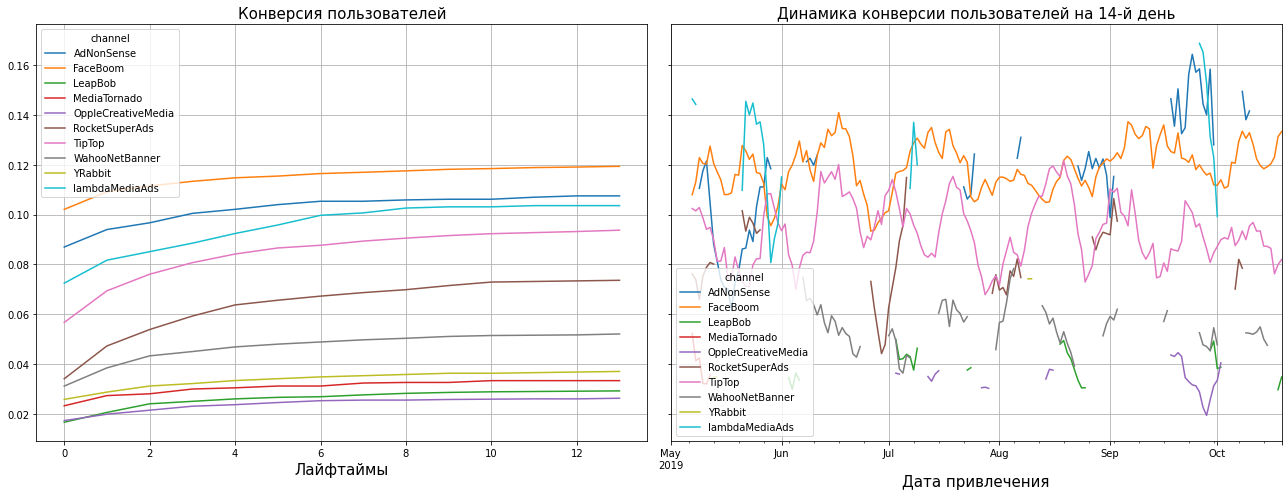

In [ ]:
plot_conversion(conversion_с, conversion_с_history, 14, 7)

#### Удержание по каналам привлечения

In [ ]:
raw_c, retention_c, retention_c_history = get_retention(non_org_profiles, visits, datetime(2019,11,1).date(), 14, dimensions=['channel'])

In [ ]:
retention_c.query('payer == True').sort_values(by=13, ascending=False)

cohort_size    0    1    2    3    4    5    6    7  \
payer channel                                                                   
True  WahooNetBanner              428 1.00 0.55 0.51 0.39 0.45 0.38 0.34 0.35   
      RocketSuperAds              335 1.00 0.57 0.47 0.40 0.39 0.33 0.32 0.33   
      OppleCreativeMedia          220 1.00 0.54 0.46 0.40 0.40 0.31 0.34 0.27   
      LeapBob                     243 1.00 0.56 0.49 0.40 0.33 0.40 0.29 0.25   
      TipTop                     1785 1.00 0.53 0.46 0.41 0.35 0.35 0.29 0.29   
      lambdaMediaAds              220 1.00 0.56 0.49 0.40 0.37 0.37 0.34 0.33   
      MediaTornado                148 1.00 0.50 0.45 0.35 0.34 0.35 0.25 0.23   
      YRabbit                     156 1.00 0.56 0.38 0.40 0.37 0.28 0.26 0.23   
      AdNonSense                  413 1.00 0.29 0.16 0.13 0.08 0.06 0.06 0.05   
      FaceBoom                   3362 1.00 0.22 0.12 0.08 0.06 0.04 0.04 0.03   

                            8    9   10   11   12   13  
payer channel                                           
True  WahooNetBanner     0.31 0.26 0.31 0.27 0.25 0.23  
      RocketSuperAds     0.26 0.29 0.32 0.23 0.28 0.22  
      OppleCreativeMedia 0.24 0.23 0.24 0.22 0.23 0.21  
      LeapBob            0.27 0.25 0.28 0.24 0.22 0.21  
      TipTop             0.28 0.26 0.25 0.24 0.23 0.21  
      lambdaMediaAds     0.27 0.21 0.22 0.18 0.20 0.19  
      MediaTornado       0.22 0.18 0.23 0.23 0.16 0.12  
      YRabbit            0.26 0.26 0.22 0.21 0.22 0.10  
      AdNonSense         0.06 0.05 0.02 0.02 0.03 0.03  
      FaceBoom           0.02 0.02 0.02 0.01 0.01 0.01

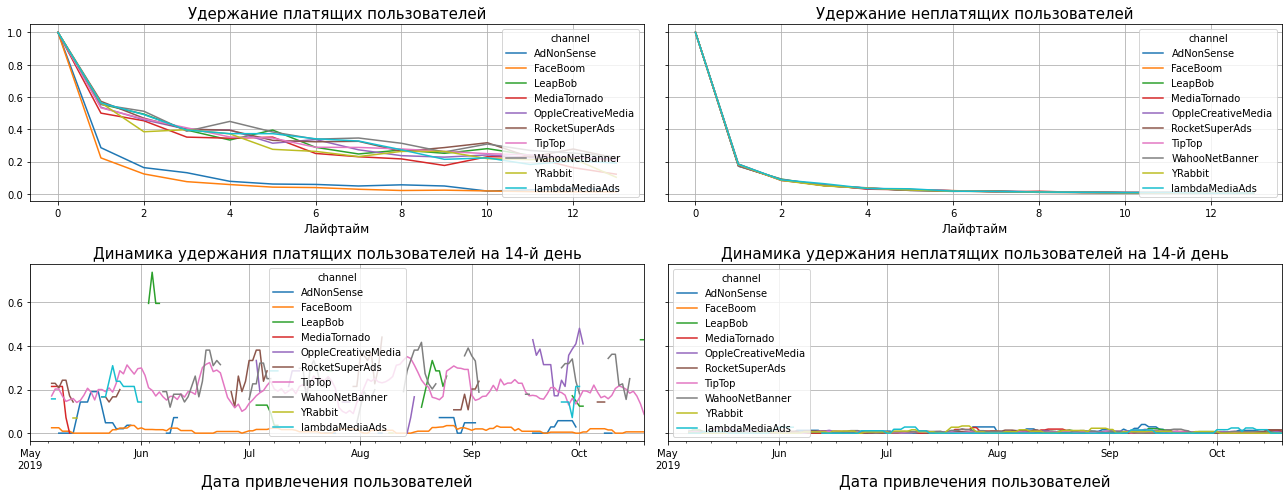

In [ ]:
plot_retention(retention_c, retention_c_history, 14,7)

#### Подитог

Обобщим, полученные результаты:

- **ДЕВАЙСЫ:**
    - Конверсия на 14-й день лучше всего у Мас - 9%, далее идут iPhone и PC - 8%, на последнем месте РС с 7%.
    - Удержание платящих пользователей на 14-й день составляет 11-12% для всех девайсов кроме iPhone, у которого 9%. Плохой показатель, учитывая, что это девайс с самой большой долей пользователей.
- **СТРАНЫ:**
    - Наилучшей конверсией на 14-й день обладают США - 10%, у остальных стран в два раза меньше - 5%, также тут стоит отметить, что доля пользователей из США самая большая.
    - А вот удержание у платящих пользователей у США наихудшее - 9% на 14-й день, далее идет Германия - 13%, а самые верные пользователи во Франции и Великобритании - 17% и 18% на 14-й день соответственно.
- **КАНАЛЫ ПРИВЛЕЧЕНИЯ:**
    - Лучшим по конверсии каналом является FaceBoom (12%), далее идут AdNonSense (11%) и lambdaMediaAds (10%), а вот TipTop имеет всего 9-процентную конверсию - не лучший канал для вложения большого объема средств. У остальных каналов конверсия еще ниже.
    - Наилучшие результаты удержания на 14-й день совсем у других платформ: WahooNetBanner (23%), RocketSuperAds(22%) и OppleCreativeMedia (21%). У TipTop этот показатель также на уровне 21%, а у FaceBoom, обладающего лучшей конверсией, удержание равно всего 1%.
    
    

### Дополнительная оценка вложений в канал TipTop.

Мы уже можем предположить, что большие вложения в TipTop не окупились. Для того, чтобы окончательно убедиться, смоделируем ситуацию, в которой деньги в TipTop не вкладывались и ни один пользователь не пришел через этот канал и посмотрим на результаты.

In [ ]:

raw, ltv_c, ltv_c_history, roi_c, roi_c_history = get_ltv(non_org_profiles.query('channel != "TipTop"'), orders, datetime(2019,11,1).date(), 14)

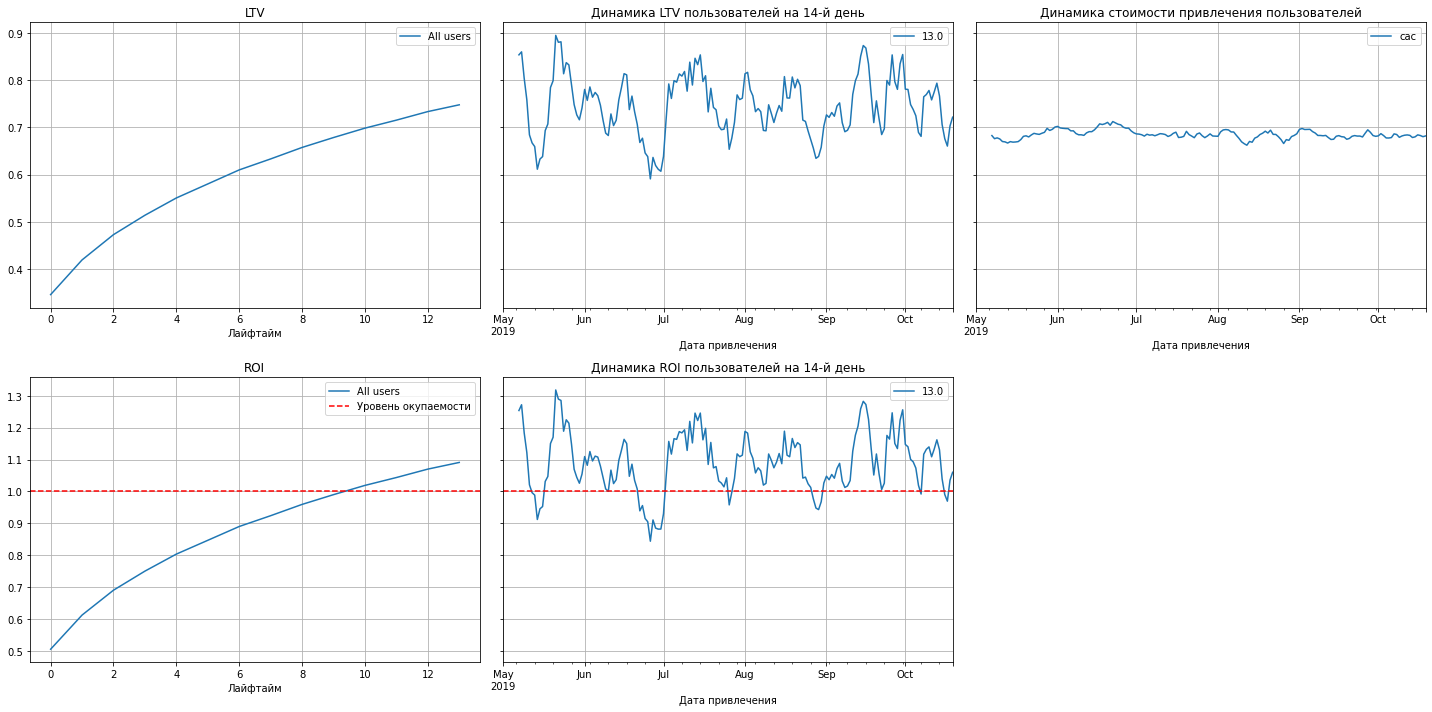

In [ ]:
plot_ltv_roi(ltv_c, ltv_c_history, roi_c, roi_c_history, 14, 7)

Как мы видим, окупаемость сразу поднимается до 110%, расходы на привлечение одного пользователя стабилизируются на отметке 0.7 у.е., а динамика ROI на 14-й день стабильно превышает 100%.

### Окупается ли реклама, направленная на привлечение пользователей в целом?

Не окупается. В целом окупаемость рекламы составляет 80%.

### Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

- **УСТРОЙСТВА:**

В большей степени негативное влияние оказывают Мас и iPhone - менее 75% окупаемости, и в меньшей степени Android - 90% окупаемости.

- **СТРАНЫ:**

Негативный эффект оказывает США - 68% окупаемости. Также в связи с большой долей этого региона в общем количестве пользователей, США тянет общую окупаемость ниже 100%, несмотря на очень хорошие значения у европейских стран (от 140 до 160 %%). С учетом наилучшего значения конверсии и самой большой доли в количестве пользователей не стоит отказываться от американского рынка, негативные значения вызваны крайне неудачной и дорогостоящей рекламной кампанией. 

- **КАНАЛЫ:**

Единственный канал, оказывающий негативный и при этом очень мощный эффект - это TipTop, окупаемость которого меньше 53%.

## Итоговые рекомендации

Из результатов анализа метрик можно сделать предположение, что в середине мая отдел маркетинга принял решение развивать самый большой рынок - американский, также LTV и ROI США на тот момент были наилучшими среди всех стран. Каналов для расширения американской аудитории был выбран TipTop.

Однако, не приняв во внимание окупаемость по странам, был выбран не тот рынок - в европейских странах окупаемость была выше. Также неверно определен канал привлечения: TipTop не смог увеличить количество пользователей сопоставимо, вложенным затратам.
При этом, видя, что TipTop не помогает завовевать аудиторию в США, вместо изменения стратегии было принято решение еще больше увеличить вложения в TipTop, что только ухудшало ситуацию с окупаемостью.

**Рекомендовано:**

- Обратить внимание на повышение уровня удержания для пользователей iPhone, а также жителей США, например добавить всплывающие напоминания о приложении.
- Рассмотреть возможность применения скидок для пользователей из европейских стран, так как конверсия в этих странах значительно отстает от конверсии в США. Возможно, стоит разработать отдельную ценовую политику для европейских стран, так как покупательская способность может отличаться от той, что есть в США.
- Отказаться от больших вложений в канал привлечения TipTop и оставить их на уровне мая 2019 года, скорректировать рекламу в FaceBoom для повышения уровня удержания пользователей, а освободившиеся средства распределить на каналы с хорошими показаателями конверсии и удержания, например AdNonSense и WahooNetBanner.